In [1]:
def elbow_plot(cluster_vars, X_train_scaled):
    # elbow method to identify good k for us
    ks = range(2,20)
    
    # empty list to hold inertia (sum of squares)
    sse = []

    # loop through each k, fit kmeans, get inertia
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train_scaled[cluster_vars])
        # inertia
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    # plot k with inertia
    plt.plot(ks, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('Elbow method to find optimal k')
    plt.show()

In [2]:
def run_kmeans(k, cluster_vars, cluster_col_name, X_train_scaled):
    # create kmeans object
    kmeans = KMeans(n_clusters = k, random_state = 13)
    kmeans.fit(X_train_scaled[cluster_vars])
    # predict and create a dataframe with cluster per observation
    train_clusters = \
        pd.DataFrame(kmeans.predict(X_train_scaled[cluster_vars]),
                              columns=[cluster_col_name],
                              index=X_train_scaled.index)
    
    return train_clusters, kmeans

In [3]:
def add_to_train(train_clusters, cluster_col_name, X_train, X_train_scaled):
    # concatenate cluster id
    X_train = pd.concat([X_train, train_clusters], axis=1)


    # concatenate cluster id
    X_train_scaled = pd.concat([X_train_scaled, train_clusters], 
                               axis=1)

    return X_train, X_train_scaled

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle_zillow import wrangle_zillow, scaled_zillow_columns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [5]:
train, validate, test = wrangle_zillow()

In [7]:
X_train = train.drop(columns=['error'])
y_train = train[['error']]

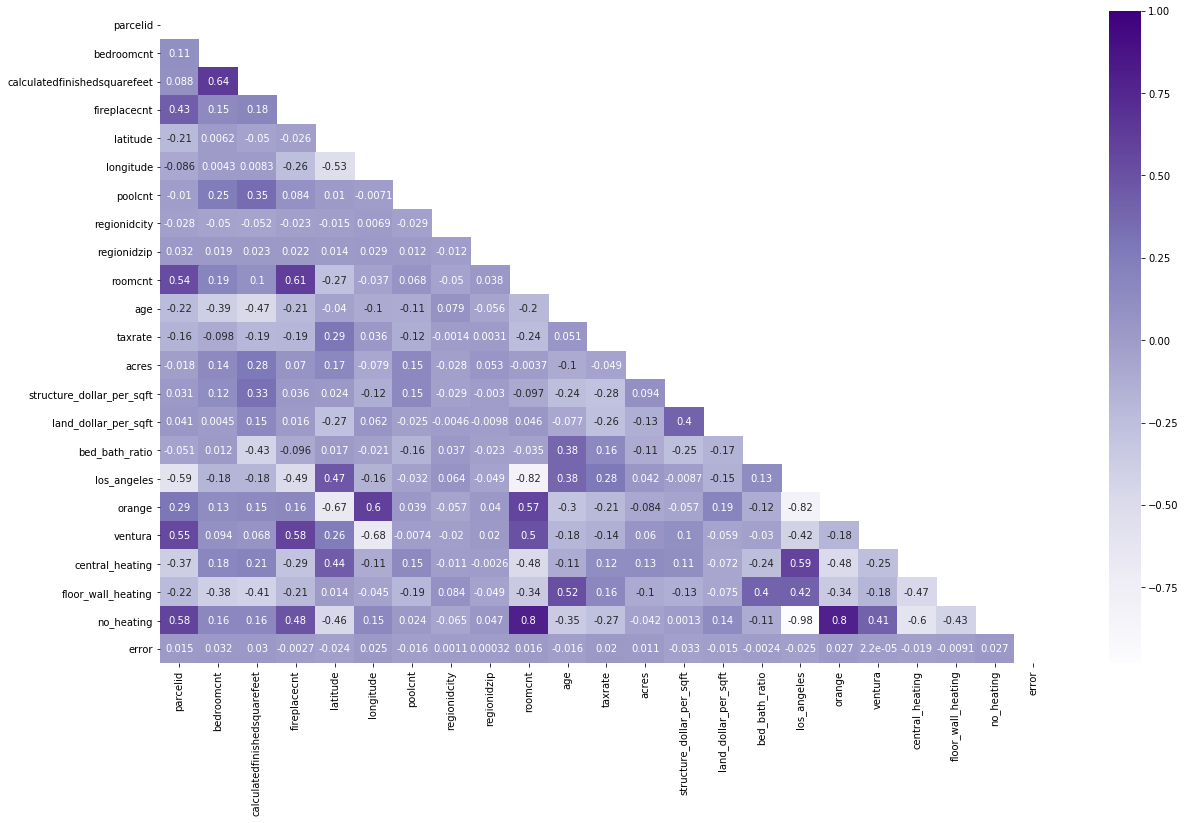

In [9]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(20,12))
sns.heatmap(train.corr(), cmap='Purples', annot=True, mask=mask)
plt.show()

In [55]:
import math
abs(train.corr().error).sort_values(ascending = False)

error                           1.000000
structure_dollar_per_sqft       0.032991
bedroomcnt                      0.031790
calculatedfinishedsquarefeet    0.030269
orange                          0.027129
no_heating                      0.027107
longitude                       0.025376
los_angeles                     0.025052
latitude                        0.023663
taxrate                         0.020288
central_heating                 0.018522
poolcnt                         0.015922
roomcnt                         0.015894
age                             0.015559
parcelid                        0.015402
land_dollar_per_sqft            0.014654
acres                           0.010879
floor_wall_heating              0.009072
fireplacecnt                    0.002726
bed_bath_ratio                  0.002376
regionidcity                    0.001073
regionidzip                     0.000318
ventura                         0.000022
Name: error, dtype: float64

Conclusion: 
- structure dollar per sqft has the highest correlation overall to logerror
- Orange and LA county are in the top 7 with having the highest correlation to logerror
- longitude and latitude are also in the top ten but that makes sense given that Orange and LA are listed higher
- because location seems to be the biggest factor, let split the data into LA and Orange county and check the logerror

In [70]:
la_error = train[train.los_angeles == 1].error
orange_error = train[train.orange == 1].error
ventura_error = train[train.ventura == 1].error

There is a difference in errors but it is significant?

In [71]:
from scipy import stats

stats.levene(la_error, orange_error, ventura_error)

LeveneResult(statistic=18.929427065016203, pvalue=6.0899900130145475e-09)

In [72]:
alpha = .05

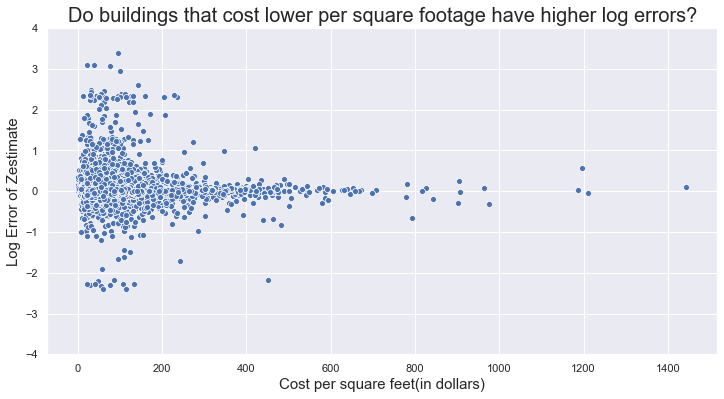

In [82]:
sns.scatterplot(x = 'structure_dollar_per_sqft', y = 'error', data = train)
plt.title("Do buildings that cost lower per square footage have higher log errors?", size = 20)
plt.xlabel("Cost per square feet(in dollars)", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.ylim(-4, 4)
sns.set(rc = {'figure.figsize':(12,9)})
plt.show()

Is there a significance?

In [84]:
null_hypothesis = "Log errors in low cost per sqft are the same as the log errors for the rest of the houses"
alternative_hypothesis = "Log errors in low cost per sqft are different than the log errors for the rest of the houses" 

In [91]:
low_cost_sqft = train[train.structure_dollar_per_sqft < 200]
t, p = stats.ttest_1samp(low_cost_sqft.error, train.error.mean())
t, p

(0.3241526634826526, 0.7458249674639328)

Is there a significant difference in logerrors between bedrooms?

In [92]:
one_bed = train[train.bedroomcnt == 1].error
two_bed = train[train.bedroomcnt == 2].error
three_bed = train[train.bedroomcnt == 3].error
four_bed = train[train.bedroomcnt == 5].error
five_bed = train[train.bedroomcnt == 4].error
six_bed = train[train.bedroomcnt == 6].error
seven_bed = train[train.bedroomcnt == 7].error

In [93]:
from scipy.stats import f_oneway

In [94]:
f, p = f_oneway(one_bed, two_bed, three_bed, four_bed, five_bed, six_bed, seven_bed)
p

1.2878894227156024e-06

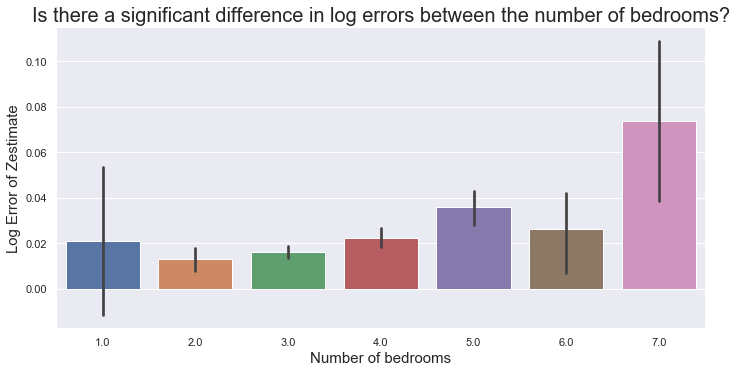

In [107]:
sns.catplot(x="bedroomcnt", y="error", kind="bar", data=train, height=5, aspect=2)
plt.title("Is there a significant difference in log errors between the number of bedrooms?", size = 20)
plt.xlabel("Number of bedrooms", size = 15)
plt.ylabel("Log Error of Zestimate", size = 15)
plt.show()

In [11]:
train_scaled, validate_scaled, test_scaled = scaled_zillow_columns()

In [12]:
X_train_scaled = train_scaled.drop(columns=['parcelid', 'transactiondate', 'error'])
y_train_scaled = train_scaled[['error']]

In [13]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   los_angeles                          27955 non-null  uint8  
 1   orange                               27955 non-null  uint8  
 2   ventura                              27955 non-null  uint8  
 3   central_heating                      27955 non-null  uint8  
 4   floor_wall_heating                   27955 non-null  uint8  
 5   no_heating                           27955 non-null  uint8  
 6   bedroomcnt_scaled                    27955 non-null  float64
 7   calculatedfinishedsquarefeet_scaled  27955 non-null  float64
 8   fireplacecnt_scaled                  27955 non-null  float64
 9   latitude_scaled                      27955 non-null  float64
 10  longitude_scaled                     27955 non-null  float64
 11  poolcnt_scaled          

In [14]:
size_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled']

In [15]:
value_vars = ['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled']

In [16]:
feature_vars = ['fireplacecnt_scaled', 'poolcnt_scaled']

     k         sse
0    2  211.828085
1    3  123.610604
2    4   86.295212
3    5   66.532673
4    6   54.867337
5    7   43.632933
6    8   36.760261
7    9   32.056177
8   10   28.511194
9   11   25.177565
10  12   22.908971
11  13   20.893364
12  14   19.109447
13  15   17.738408
14  16   16.382904
15  17   15.402970
16  18   14.527924
17  19   13.707803


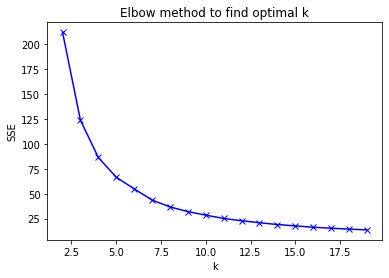

In [17]:
elbow_plot(size_vars, X_train_scaled)

In [18]:
train_clusters, kmeans = run_kmeans(5,  cluster_vars = ['calculatedfinishedsquarefeet_scaled', 'acres_scaled'], 
                                    cluster_col_name = 'size_cluster', X_train_scaled = X_train_scaled)

In [19]:
train_clusters.size_cluster.value_counts()

3    10451
0     9261
1     5264
4     2372
2      607
Name: size_cluster, dtype: int64

In [20]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'size_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      27955 non-null  int64  
 1   bedroomcnt                    27955 non-null  float64
 2   calculatedfinishedsquarefeet  27955 non-null  float64
 3   fireplacecnt                  27955 non-null  float64
 4   latitude                      27955 non-null  float64
 5   longitude                     27955 non-null  float64
 6   poolcnt                       27955 non-null  float64
 7   regionidcity                  27955 non-null  float64
 8   regionidzip                   27955 non-null  float64
 9   roomcnt                       27955 non-null  float64
 10  transactiondate               27955 non-null  object 
 11  age                           27955 non-null  float64
 12  taxrate                       27955 non-null  float64
 1

     k           sse
0    2  3.429006e+02
1    3  1.487554e+02
2    4  5.300229e+01
3    5  2.884431e+01
4    6  8.071085e+00
5    7  3.809558e+00
6    8  6.694602e-01
7    9  1.772727e-01
8   10  1.098326e-22
9   11  1.098326e-22
10  12  1.098326e-22
11  13  1.098326e-22
12  14  1.098326e-22
13  15  1.098326e-22
14  16  1.098326e-22
15  17  1.098326e-22
16  18  1.098326e-22
17  19  1.098326e-22


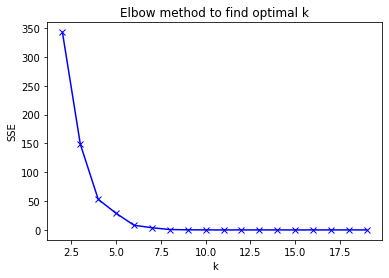

In [22]:
elbow_plot(feature_vars, X_train_scaled)

In [23]:
train_clusters, kmeans = run_kmeans(4,  cluster_vars = ['fireplacecnt_scaled', 'poolcnt_scaled'], 
                                    cluster_col_name = 'feature_cluster', X_train_scaled = X_train_scaled)

In [24]:
train_clusters.feature_cluster.value_counts()

0    19450
1     4765
2     2768
3      972
Name: feature_cluster, dtype: int64

In [25]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'feature_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

In [48]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      27955 non-null  int64  
 1   bedroomcnt                    27955 non-null  float64
 2   calculatedfinishedsquarefeet  27955 non-null  float64
 3   fireplacecnt                  27955 non-null  float64
 4   latitude                      27955 non-null  float64
 5   longitude                     27955 non-null  float64
 6   poolcnt                       27955 non-null  float64
 7   regionidcity                  27955 non-null  float64
 8   regionidzip                   27955 non-null  float64
 9   roomcnt                       27955 non-null  float64
 10  transactiondate               27955 non-null  object 
 11  age                           27955 non-null  float64
 12  taxrate                       27955 non-null  float64
 1

     k        sse
0    2  57.371925
1    3  42.543065
2    4  34.624701
3    5  27.199504
4    6  22.422642
5    7  19.451573
6    8  16.717979
7    9  14.929574
8   10  13.401719
9   11  12.111729
10  12  11.157645
11  13  10.263645
12  14   9.464195
13  15   8.756110
14  16   8.120081
15  17   7.577475
16  18   7.189123
17  19   6.852307


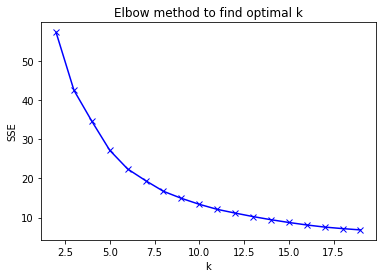

In [26]:
elbow_plot(value_vars, X_train_scaled)

In [27]:
train_clusters, kmeans = run_kmeans(6,  cluster_vars = ['structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled'], 
                                    cluster_col_name = 'value_cluster', X_train_scaled = X_train_scaled)

In [28]:
train_clusters.value_cluster.value_counts()

5    12692
0     9619
2     3900
1     1420
4      253
3       71
Name: value_cluster, dtype: int64

In [29]:
X_train, X_train_scaled = add_to_train(train_clusters, cluster_col_name = 'value_cluster', X_train = X_train, X_train_scaled = X_train_scaled)

In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      27955 non-null  int64  
 1   bedroomcnt                    27955 non-null  float64
 2   calculatedfinishedsquarefeet  27955 non-null  float64
 3   fireplacecnt                  27955 non-null  float64
 4   latitude                      27955 non-null  float64
 5   longitude                     27955 non-null  float64
 6   poolcnt                       27955 non-null  float64
 7   regionidcity                  27955 non-null  float64
 8   regionidzip                   27955 non-null  float64
 9   roomcnt                       27955 non-null  float64
 10  transactiondate               27955 non-null  object 
 11  age                           27955 non-null  float64
 12  taxrate                       27955 non-null  float64
 1

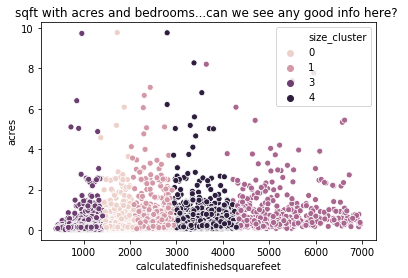

In [32]:
sns.scatterplot(x='calculatedfinishedsquarefeet', y='acres', hue='size_cluster', data=X_train)
plt.title("sqft with acres and bedrooms...can we see any good info here? ")
plt.show()

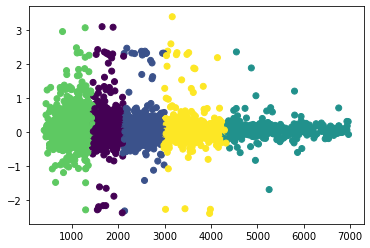

In [33]:
plt.scatter(X_train.calculatedfinishedsquarefeet, y_train.error, c=X_train.size_cluster)
plt.show()

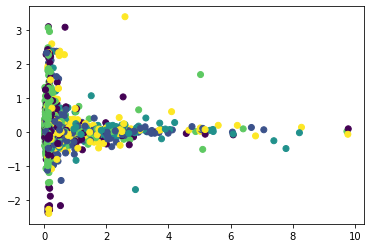

In [34]:
plt.scatter(X_train.acres, y_train.error, c=X_train.size_cluster)
plt.show()

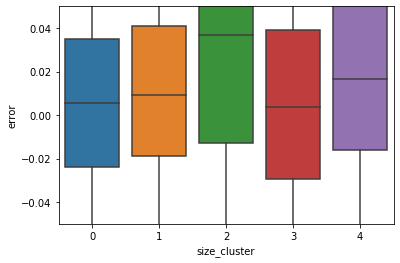

In [35]:
sns.boxplot(X_train.size_cluster, y_train.error)
plt.ylim(-.05,.05)
plt.show()

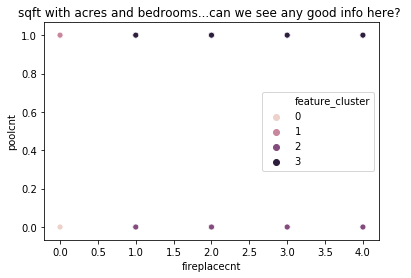

In [36]:
sns.scatterplot(x='fireplacecnt', y='poolcnt', hue='feature_cluster', data=X_train)
plt.title("sqft with acres and bedrooms...can we see any good info here? ")
plt.show()

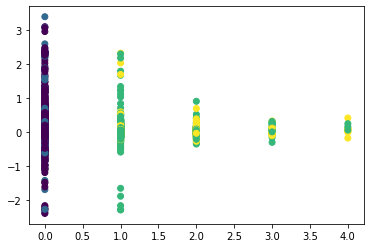

In [37]:
plt.scatter(X_train.fireplacecnt, y_train.error, c=X_train.feature_cluster)
plt.show()

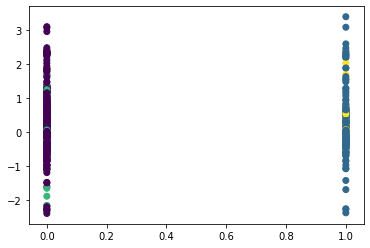

In [38]:
plt.scatter(X_train.poolcnt, y_train.error, c=X_train.feature_cluster)
plt.show()

(-1, 1)

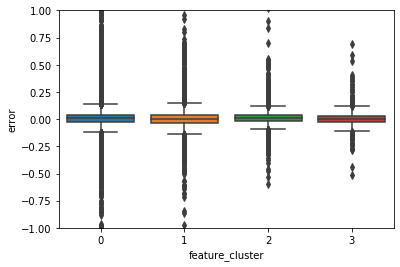

In [39]:
sns.boxplot(X_train.feature_cluster, y_train.error)
plt.ylim(-1,1)

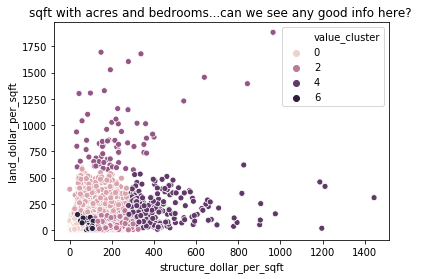

In [40]:
sns.scatterplot(x='structure_dollar_per_sqft', y='land_dollar_per_sqft', hue='value_cluster', data=X_train)
plt.title("sqft with acres and bedrooms...can we see any good info here? ")
plt.show()

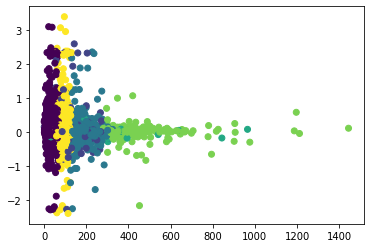

In [41]:
plt.scatter(X_train.structure_dollar_per_sqft, y_train.error, c=X_train.value_cluster)
plt.show()

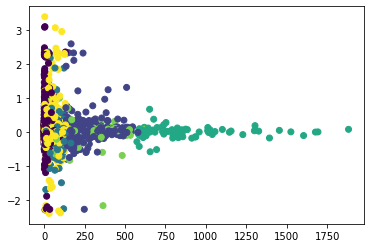

In [42]:
plt.scatter(X_train.land_dollar_per_sqft, y_train.error, c=X_train.value_cluster)
plt.show()

(-1, 1)

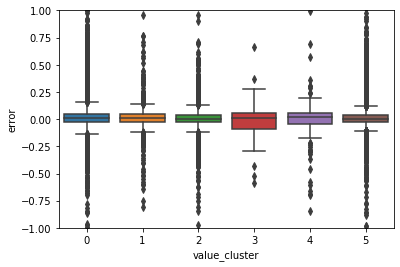

In [43]:
sns.boxplot(X_train.value_cluster, y_train.error)
plt.ylim(-1,1)

In [44]:
dummy_df = pd.get_dummies(X_train_scaled,
                           columns=['size_cluster','feature_cluster', 'value_cluster'], 
                           drop_first=True)

In [45]:
X_train_scaled = dummy_df.drop(columns=['fireplacecnt_scaled', 'poolcnt_scaled', 'structure_dollar_per_sqft_scaled', 'land_dollar_per_sqft_scaled','calculatedfinishedsquarefeet_scaled', 'acres_scaled'])

In [46]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27955 entries, 32407 to 16021
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   los_angeles            27955 non-null  uint8  
 1   orange                 27955 non-null  uint8  
 2   ventura                27955 non-null  uint8  
 3   central_heating        27955 non-null  uint8  
 4   floor_wall_heating     27955 non-null  uint8  
 5   no_heating             27955 non-null  uint8  
 6   bedroomcnt_scaled      27955 non-null  float64
 7   latitude_scaled        27955 non-null  float64
 8   longitude_scaled       27955 non-null  float64
 9   regionidcity_scaled    27955 non-null  float64
 10  regionidzip_scaled     27955 non-null  float64
 11  roomcnt_scaled         27955 non-null  float64
 12  age_scaled             27955 non-null  float64
 13  taxrate_scaled         27955 non-null  float64
 14  bed_bath_ratio_scaled  27955 non-null  float64
 15

In [57]:
X_train_scaled[X_train_scaled.los_angeles == 1]


,los_angeles,orange,ventura,central_heating,floor_wall_heating,no_heating,bedroomcnt_scaled,latitude_scaled,longitude_scaled,regionidcity_scaled,...,size_cluster_3,size_cluster_4,feature_cluster_1,feature_cluster_2,feature_cluster_3,value_cluster_1,value_cluster_2,value_cluster_3,value_cluster_4,value_cluster_5
32407,1,0,0,0,1,0,0.333333,0.408956,0.631454,0.022785,...,1,0,0,0,0,0,0,0,0,1
32997,1,0,0,1,0,0,0.333333,0.592642,0.470356,0.022785,...,1,0,0,0,0,0,0,0,0,1
32855,1,0,0,1,0,0,0.333333,0.524016,0.603857,0.022785,...,0,0,0,0,0,1,0,0,0,0
24544,1,0,0,1,0,0,0.333333,0.344848,0.688123,0.022391,...,0,0,0,0,0,0,1,0,0,0
43175,1,0,0,0,1,0,0.333333,0.336347,0.713864,0.022391,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16622,1,0,0,0,1,0,0.166667,0.484537,0.575058,0.022785,...,1,0,0,0,0,0,0,0,0,1
10502,1,0,0,0,1,0,0.500000,0.523269,0.768032,0.120229,...,1,0,0,0,0,0,0,0,0,0
50088,1,0,0,0,1,0,0.500000,0.385454,0.587144,0.098353,...,0,0,0,0,0,0,0,0,0,1
2850,1,0,0,0,1,0,0.333333,0.313944,0.578658,0.130337,...,0,0,0,0,0,0,0,0,0,0


In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lm = LinearRegression()
rfe_ = RFE(lm, 1)
rfe_.fit(X_train_scaled, y_train_scaled)
ranks = rfe_.ranking_
names = X_train_scaled.columns.tolist()
pd.DataFrame({'features': names, 'rank': ranks}).sort_values('rank')

,features,rank
1,orange,1
2,ventura,2
0,los_angeles,3
5,no_heating,4
4,floor_wall_heating,5
3,central_heating,6
13,taxrate_scaled,7
6,bedroomcnt_scaled,8
8,longitude_scaled,9
24,value_cluster_3,10


In [47]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train.error)
y_hat = lm.predict(X_train_scaled)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_train.error, y_hat)**(1/2)


0.1711051220673486

centroid_calculatedfinishedsquarefeet_scaled
centroid_acres_scaled
centroid_fireplacecnt_scaled
centroid_poolcnt_scaled
centroid_structure_dollar_per_sqft_scaled
centroid_land_dollar_per_sqft_scaled 